In [4]:
import random as rand
import statistics as stat
# Geometric distribution
def geoDist(p):
    c = 1
    while (rand.random() >= p):
        c += 1
    return c

In [3]:
print(stat.mean([geoDist(0.5) for _ in range(100)]))

1.95


In [13]:
import random as rand
from collections import deque
import math

# Jobs are handled by servers
class Job:
    
    # Constructor
    def __init__(self,a,s):
        # Arrival time
        self.arrTime = a 
        
        # Job size
        self.size = s
        
        # Departure time
        self.departed = 0
        
        # The number of other jobs in front of it when it arrives at the server
        self.numinfront = 0 
    
    # Allows printing    
    def __str__(self):
        return str(self.arrTime) +", "+ str(self.size)

# The job handler. Multiple can exist within each QueueingSystem
class Server:
    
    # Constructor
    def __init__(self, n):
        # Identifier to keep track of it during debug
        self.name = n
        
        # Whether or not it is doing a job
        self.idle = True
        
        # The job it is currently working on
        self.curJob = None
        
        # The time at which its current job departs
        self.departure = 1
        
        # Its list of jobs to do, does not include the one it is working on
        self.queue = deque()
    
    # Called when one of the server is done with a job, first checks if this server
    # is scheduled to finish at the current time, and takes care of updating the
    # queue and associated fields. If the queue is empty, the server becomes idle.
    def update(self, curTime):
        if self.curJob != None and curTime == self.departure:
            finished = self.curJob
            self.curJob.departed = curTime
            if len(self.queue) == 0:
                self.curJob = None
                self.idle = True
            else:
                self.curJob = self.queue.popleft()
                self.departure = self.curJob.size + curTime
                self.idle = False
            return finished, self.idle
        return None

    # Called by the dispatcher. Adds a job to self.queue which is a FCFS structure.
    # If the server is idle, the server immediately begins working on the assigned job
    # and does not add it to self.queue.
    def addJob(self, j, curTime):
        j.numinfront = len(self.queue) + int(not self.idle)
        if (self.idle):
            self.curJob = j
            self.departure = j.size+curTime
            self.idle = False
        else:
            self.queue.append(j)

    # Printing capabilities
    def __str__(self):
        return self.name

# Manages the entire operation
class QueueingSystem:
    
    # Constructor
    def __init__(self, nservers, p, q, njobs, dispatcher = 'JIQ', v=False):
        
        # The list of jobs to be completed during self.run()
        self.jobslist = deque()
        t = 0 # time of the first job
        for _ in range(njobs):
            self.jobslist.append(Job(t,geoDist(q)))
            t+=geoDist(p)
            
        # The list of servers in the system
        self.serverlist = [Server("#"+str(i)) for i in range(nservers)]
        
        # The list of servers in the system that are not idle
        self.activeservers = []

        # The list of idle servers in the system
        self.idleservers = [s for s in self.serverlist]
                
        # Where jobs go after a server completes them
        self.completedjobs = []
        
        # Enables print statements
        self.verbose = v
        
        # Distributor 
        self.dispatcher = self.distJIQ
        
        self.bigservers = self.serverlist[0:int(nservers/2)]
        self.smallservers = self.serverlist[int(nservers/2):]
        self.medianJobSize = 0
        if dispatcher == "BS" and nservers>1:
            self.dispatcher = self.distBigSmall
            temp = []
            for i in range(min(njobs,100)):
                temp += [self.jobslist[i].size]
            self.medianJobSize = stat.median(temp)
            
            
        # Debug printing    
        if(self.verbose):
            for j in self.jobslist:
                print(j)
            for s in self.serverlist:
                print(s)

    # The simulation method. Jumps through time by finding the next time where a job
    # arrives or is finished by one of the servers. Note the <= signs mean both if
    # statements run when a job arrives and a job departs at the same time.
    def run(self):
        systime = 0
        
        # The main loop
        while(len(self.jobslist)!=0):
            
            # Debug printing 
            if(self.verbose):
                self.printserverinfo()
            
            # Calculating the next departure of the servers and the next arrival in the
            # job list. If all of the servers are idle, nextDeparture is 2 billion to 
            # prevent it from being less than nextArrival. In very large simulations, a
            # better work around should be implemented.
            nextArrival = self.jobslist[0].arrTime
            nextDeparture = min([2147483647]+[s.departure for s in self.activeservers])
            
            # Debug printing 
            if(self.verbose):
                print("Next Arrival: %d, Next Departure: %d" %(nextArrival,nextDeparture))
            
            
            if(nextDeparture <= nextArrival):
                systime = nextDeparture
                for s in self.activeservers:
                    x = s.update(systime)
                    if x != None: # if the server actually departed when we called .update
                        self.completedjobs += [x[0]]
                        if x[1] == True: # if the server is now idle
                            self.activeservers.remove(s)
                            self.idleservers.append(s)
    
                        # Debug printing 
                        if(self.verbose):
                            print("%s finished a job at %d! WOW!"%(s,systime))
                        
            if(nextArrival <= nextDeparture):
                systime = nextArrival
                self.dispatcher(systime) #distributes the job to one of the servers
        
        return self.completedjobs
    
    ##########################
    # DISPATCHING POLICIES
    ##########################
    
    # The default dispatching policy, assigns the job to a randomly chosen idle server.
    # If no server is idle, then a random active server is chosen instead.
    def distJIQ(self,systime):
        if len(self.idleservers) != 0 : # >=1 server is idle
            
            # Randomly selects a server in idleservers
            i = rand.randint(0,len(self.idleservers)-1)
            chosen = self.idleservers[i]
            
            # Manages idle/active server lists
            self.idleservers.remove(chosen)
            self.activeservers.append(chosen)

            j = self.jobslist.popleft()
            chosen.addJob(j,systime)
            

        else: # No server is idle
            
            # Randomly selects a server in activeservers
            i = rand.randint(0,len(self.activeservers)-1)
            chosen = self.activeservers[i]
            
            j = self.jobslist.popleft()
            chosen.addJob(j,systime)
            
            # Debug printing 
            if(self.verbose):
                print(chosen.name + " given a job!")
                
    def distBigSmall(self, systime):
        j = self.jobslist.popleft()
        if j.size >= self.medianJobSize:
            i = rand.randint(0,len(self.bigservers)-1)
            chosen = self.bigservers[i]
            chosen.addJob(j,systime)
        else :
            i = rand.randint(0,len(self.smallservers)-1)
            chosen = self.smallservers[i]
            chosen.addJob(j,systime)

    # Useful for debugging server idle management
    def printserverinfo(self):
        print("Active Servers: ", end="")
        for s in self.activeservers:
            print(s, end=" ")
        print("|| Idle Servers: ", end="")
        for s in self.idleservers:
            print(s, end=" ")
        print("")

            
        

In [14]:
Q = QueueingSystem(2,.9,.1,50, dispatcher='BS',v=False)

In [15]:
data = Q.run()

In [7]:
'''
jobs = 10000
k = 2000
ETs = []
ENs = []
ps = []
for i in range(1,50):
    p = i*0.01
    Q = QueueingSystem(1,p,0.5,jobs)
    jobsdata = Q.run()
    Tdata = [j.departed-j.arrTime for j in jobsdata[k:]]
    Ndata = [j.numinfront for j in jobsdata[k:]]
    ps += [p]
    ETs += [stat.mean(Tdata)]
    ENs += [stat.mean(Ndata)]
'''

'\njobs = 10000\nk = 2000\nETs = []\nENs = []\nps = []\nfor i in range(1,50):\n    p = i*0.01\n    Q = QueueingSystem(1,p,0.5,jobs)\n    jobsdata = Q.run()\n    Tdata = [j.departed-j.arrTime for j in jobsdata[k:]]\n    Ndata = [j.numinfront for j in jobsdata[k:]]\n    ps += [p]\n    ETs += [stat.mean(Tdata)]\n    ENs += [stat.mean(Ndata)]\n'

In [10]:
jobs = 10000
k = 2500
serverLim = 8
numTrials = 20
ETs = []
numServers = []
Variances = []
p = 0.5
for i in range(1,serverLim + 1):
    serverET = []
    numServers += [i]
    for k in range(0,numTrials):
        Q = QueueingSystem(i,p,0.11,jobs)
        jobsdata = Q.run()
        Tdata = [j.departed-j.arrTime for j in jobsdata[k:]]
        serverET += [stat.mean(Tdata)]
    ETs += [stat.mean(serverET)]
    Variances += [stat.variance(serverET)]  

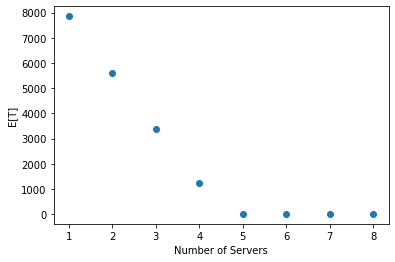

In [11]:
from matplotlib import pyplot as plt

'''
plt.scatter(ps, ETs)
plt.xlabel("p")
plt.ylabel("E[T]")
plt.show()
'''
plt.scatter(numServers,ETs)
plt.xlabel("Number of Servers")
plt.ylabel("E[T]")
plt.show()


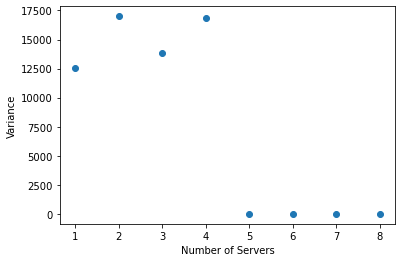

In [12]:
'''
plt.scatter(ps, ENs)
plt.xlabel("p")
plt.ylabel("E[N]")
plt.show()
'''
plt.scatter(numServers,Variances)
plt.xlabel("Number of Servers")
plt.ylabel("Variance")
plt.show()

Citations: None